# Jupyter notebook to plot the saved results

## Importing required header files

In [1]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../../../FinRL/')
sys.path.append("../FinRL-Library")

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint
import itertools
import warnings
warnings.filterwarnings("ignore")


/home/gurmehar/anaconda3/envs/finrl/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## Plotting individual results

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2021-04-06
End date,2022-04-01
Total months,12
,Backtest
Annual return,14.5%
Cumulative returns,14.5%
Annual volatility,14.4%
Sharpe ratio,1.01
Calmar ratio,1.22
Stability,0.69
Max drawdown,-11.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.85,2022-01-04,2022-03-11,NaT,NaN
1,6.12,2021-09-02,2021-10-04,2021-11-01,43
2,5.43,2021-06-04,2021-06-18,2021-06-30,19
3,4.52,2021-11-24,2021-12-01,2021-12-07,10
4,3.61,2021-07-12,2021-07-19,2021-07-23,10


Stress Events,mean,min,max
New Normal,0.06%,-3.73%,2.68%


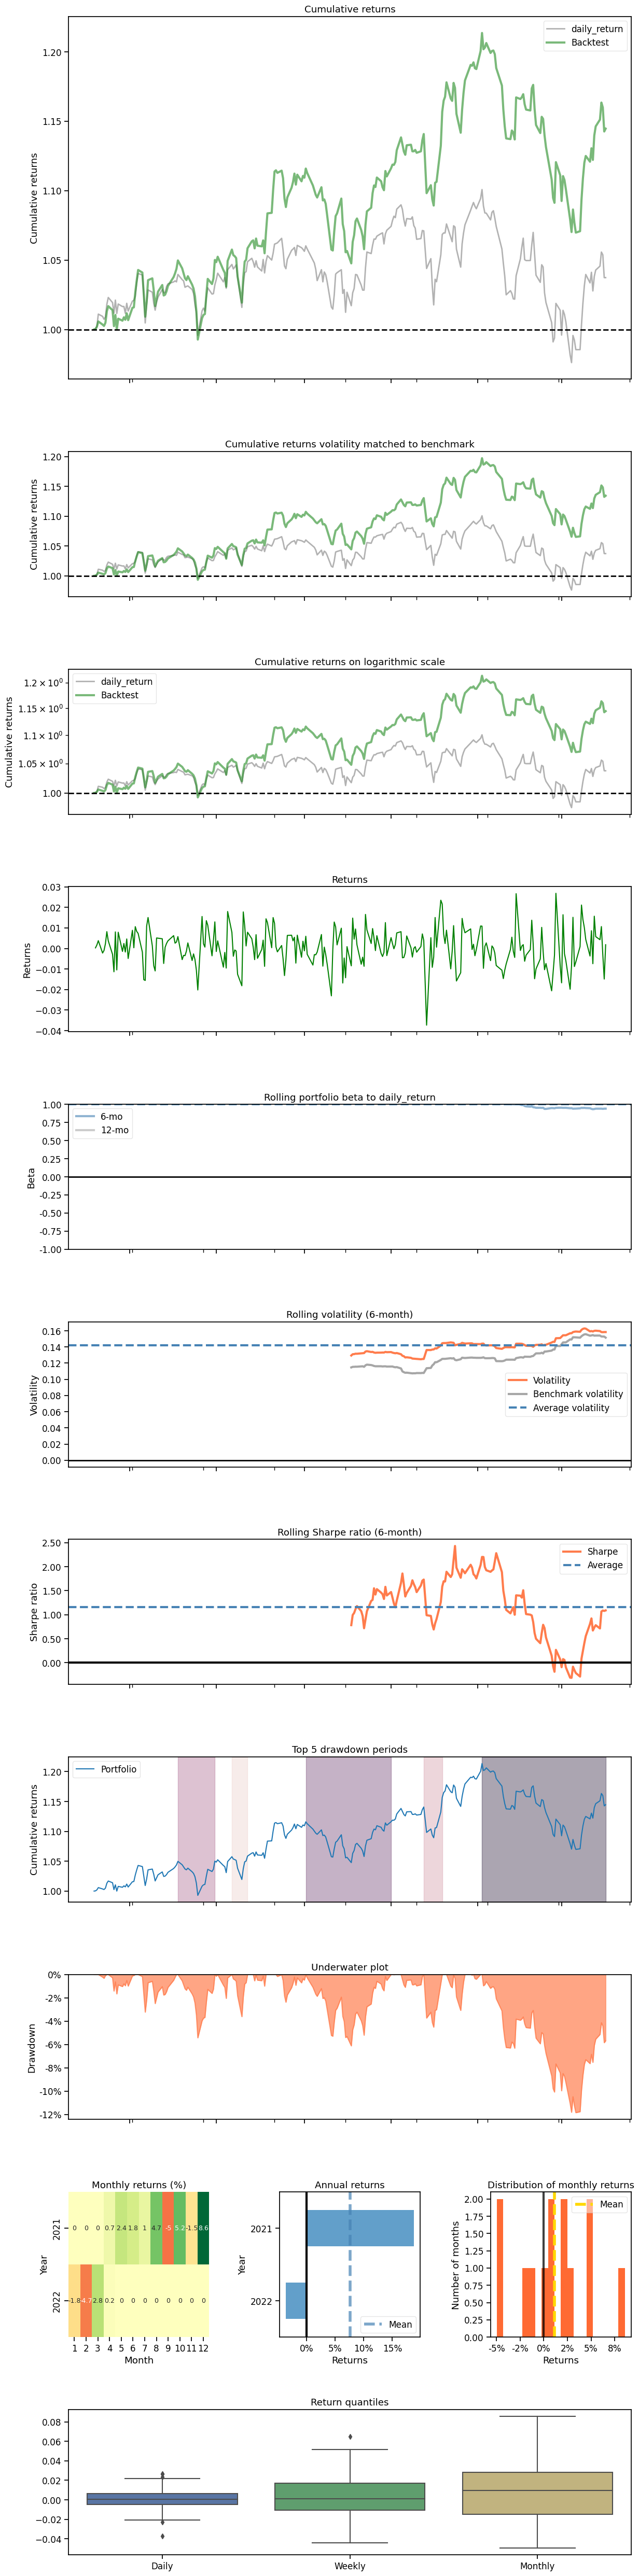

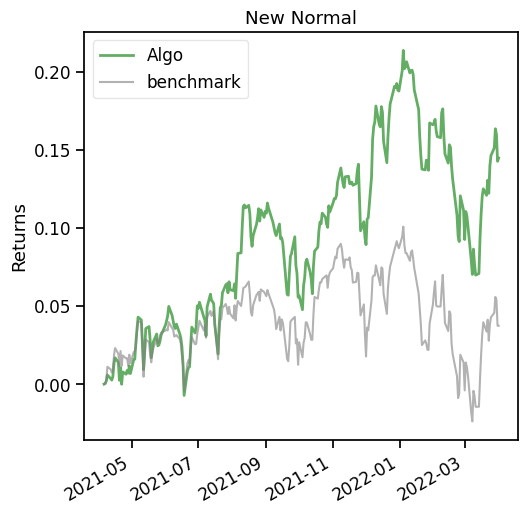

In [5]:
seed = 0
window_size = 63
retrain_window = 63
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = True
reward_type = "Profit"
result_path = 'results/overnight_run'
file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,retrain_window,use_extra_features, seed)
file = pd.read_csv(file_name)
df_account_value = file.copy()


%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [6]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Backtest Results===========
Annual return          0.144699
Cumulative returns     0.144699
Annual volatility      0.144408
Sharpe ratio           1.011763
Calmar ratio           1.221146
Stability              0.687340
Max drawdown          -0.118494
Omega ratio            1.181046
Sortino ratio          1.494889
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.023821
Daily value at risk   -0.017614
dtype: float64
==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970

## Plotting multiple seeds

In [7]:
seeds = [0,1,2,3,4]
window_size = 63
# retrain_window = 21
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = True
reward_type = "Sharpe"
result_path = 'results/overnight_run_different_indicators'
dfs = []
for seed in seeds:
    file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,window_size,use_extra_features, seed)
    file = pd.read_csv(file_name)
    dfs.append(file.copy())

# df_account_value = file.copy()


In [8]:

window = 5
dates = dfs[0].date
def plot_multiple_seeds(dfs,seeds,window = 1,use_extra_features = True, color1 = 'r', color2 = 'b',reward_type = 'Sortino',window_size = 63):
    account_list = []
    for df in dfs:
        assert dates.compare(df['date']).empty # Making sure the dates/periods are the same
        account_list.append(df['account_value']/1e6)
    all_accounts = pd.concat(account_list, axis = 1)
    new_columns = ["seed_"]*len(seeds)
    new_columns = [new_columns[i]+str(seeds[i]) for i in range(len(new_columns))]
    all_accounts.columns = new_columns
    # all_accounts.head(10)
    all_accounts['mean'] = all_accounts.mean(axis = 1)
    all_accounts['std_dev'] = all_accounts.std(axis = 1)
    all_accounts['max_val'] = all_accounts['mean'] + 2*all_accounts['std_dev']
    all_accounts['min_val'] = all_accounts['mean'] - 2*all_accounts['std_dev']
    all_accounts['rolling_mean'] =  all_accounts['mean'].rolling(window).mean()
    all_accounts['rolling_std_dev'] =  all_accounts['std_dev'].rolling(window).mean()
    all_accounts['rolling_max_val'] = all_accounts['rolling_mean'] + 2*all_accounts['rolling_std_dev']
    all_accounts['rolling_min_val'] = all_accounts['rolling_mean'] - 2*all_accounts['rolling_std_dev']
    # for col in new_columns:
    #     plt.plot(all_accounts.index,all_accounts[col])
    # plt.plot(all_accounts.index,all_accounts['mean'])
    # plt.plot(all_accounts.index,all_accounts['min_val'],'b')
    # plt.plot(all_accounts.index,all_accounts['max_val'],'b')
    # plt.fill_between
    plt.plot(all_accounts.index,all_accounts['rolling_mean'],color1,label = "Mean" )
    plt.plot(all_accounts.index,all_accounts['rolling_min_val'],color2, label = "95% CI upper")
    plt.plot(all_accounts.index,all_accounts['rolling_max_val'],color2, label = "95% CI lower")
    plt.fill_between(all_accounts.index, all_accounts['rolling_max_val'], all_accounts['rolling_min_val'], color= color2,alpha=0.1)
    plt.ylim(0.8,1.25)
    plt.xlim(0,252)
    plt.plot(all_accounts.index,[1]*len(all_accounts.index),'k--')
    plt.legend(loc="upper left")
    plt.show()
    # if(use_extra_features == True):
    #     plt.title("Fraction account value, run with {} as metric over {} seeds with window size {} and extra features".format(reward_type,len(seeds),window_size))
        
    # else:
    #     plt.title("Fraction account value, run with {} as metric over {} seeds with window size {}".format(reward_type,len(seeds),window_size))
# all_accounts.head(20)



In [9]:
def compute_avg_stats_multiple_seeds(dfs):
    n = len(dfs)
    stats = backtest_stats(dfs[0], value_col_name='account_value')
    for i in range(1,n):
        stats +=backtest_stats(dfs[i], value_col_name='account_value')
    stats[0] = stats[0]*100
    return stats/n

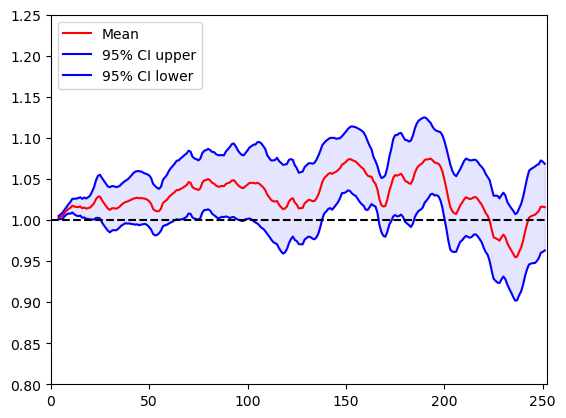

Sortino_True_window63_rolling5_5seeds_delta_diff_indicators

Annual return          0.007448
Cumulative returns     0.007448
Annual volatility      0.156114
Sharpe ratio           0.125509
Calmar ratio           0.047865
Stability              0.016805
Max drawdown          -0.155597
Omega ratio            1.021897
Sortino ratio          0.177909
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.983575
Daily value at risk   -0.019591
dtype: float64
Annual return         -0.006186
Cumulative returns    -0.006186
Annual volatility      0.146399
Sharpe ratio           0.030366
Calmar ratio          -0.041467
Stability              0.000092
Max drawdown          -0.149168
Omega ratio            1.005061
Sortino ratio          0.043326
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.013030
Daily value at risk   -0.018427
dtype: float64
Annual return          0.021580
Cumulative returns     0.021580
Annual volati

In [17]:
seeds = [0,1,2,3,4]
window_size = 63
window = 5
# retrain_window = 21
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = True
delta = True
# reward_type = "Sharpe"
reward_type = "Sortino"
# reward_type = "Profit"
if(delta == True):
    result_path = 'results/overnight_run_delta_different_indicators'
else:
    result_path = 'results/overnight_run_different_indicators'
dfs = []
for seed in seeds:
    file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,window_size,use_extra_features, seed)
    file = pd.read_csv(file_name)
    dfs.append(file.copy())

plot_multiple_seeds(dfs,seeds,window,use_extra_features,'red','blue',reward_type,window_size)

if(delta == True):
    print("{}_{}_window{}_rolling{}_{}seeds_delta_diff_indicators\n".format(reward_type,use_extra_features,window_size,window,len(seeds)))
else:
    print("{}_{}_window{}_rolling{}_{}seeds_diff_indicators\n".format(reward_type,use_extra_features,window_size,window,len(seeds)))

avg_stats = compute_avg_stats_multiple_seeds(dfs)


In [11]:
print(avg_stats.round(3)[[0,3,6,8]])

Annual return    1.036
Sharpe ratio     0.148
Max drawdown    -0.142
Sortino ratio    0.210
dtype: float64
